# Biot oscillations
Supplementary material to _The essence of Biot waves in an oscillator with two degrees of freedom_ by [Dominik Kern](https://orcid.org/0000-0002-1958-2982) and [Thomas Nagel](https://orcid.org/0000-0001-8459-4616), 2024.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
#import tikzplotlib

Spatial discretization by the mode shape ($k$th mode) of an elastic bar and the assumption that the fluid moves proportional to the solid
\begin{align}
u_\text{f}(t,x) &= U_\text{f}(t)\sin\biggl(\Bigl(k+ \frac{1}{2}\Bigr)\pi x \biggr), \\
u_\text{s}(t,x) &= U_\text{s}(t)\sin\biggl(\Bigl(k+ \frac{1}{2}\Bigr)\pi x \biggr). 
\end{align}
corresponding to a bar of unit-length with boundary conditions fixed-symmetric for S-waves (one half of a fixed-fixed bar) or fixed-free for P-waves.
Temporal discretization (exponential ansatz with $\hat{U}_\text{f}$, $\hat{U}_\text{s}$, $\delta\in\mathbb{C}$), such that coefficients in characteristic equation remain in real domain ($a_i\in\mathbb{R}$)
\begin{align}
U_\text{f}(t) &= \hat{U}_\text{f}\, e^{\delta t}, \\
U_\text{s}(t) &=  \hat{U}_\text{s}\, e^{\delta t}.
\end{align}

Note that the real part of the coefficient $\mathfrak{R}\{\delta\}$ describes decay and the imaginary part $\mathfrak{I}\{\delta\}$ oscillation.

The original equations are related to domain length $L$ and reference time $T=L\sqrt{m_\text{v} \rho_\text{s}}$ to make them non-dimensional, note $c_\mathrm{P}^\mathrm{el}=\frac{1}{\sqrt{m_\text{v} \rho_\text{s}}}$.

## Parameters
The continuum parameters are
- $L$ domain length [m],
- $\varrho_\text{f}$ fluid density [kg m$^{-3}$],
- $\varrho_\text{s}$ solid density [kg m$^{-3}$],
- $m_\text{v}$ one-dimensional soil compressibility (inverse P-wave modulus) [Pa$^{-1}$],
- $G$ shear modulus (bulk) [Pa],
- $S_p$ storativity [Pa$^{-1}$],
- $\mu$ viscosity [Pa s],
- $\kappa$ permeability [m$^2$],
- $\alpha$ Biot coefficient,
- $n$ porosity,
- $\tau$ tortuosity factor.

Declare variables for dimensional and non-dimensional parameters

In [2]:
L, G, m_v, n, S, alpha, kappa, mu, rho_f, rho_s, tau = sp.symbols('L G m_v n S alpha kappa mu rho_f rho_s tau') 
I_11, I_12, I_22, M, D_P, D_S, RHO, x, k, g = sp.symbols('I_11 I_12 I_22 M D_P D_S RHO x k g') 

Example of some soil [Verruijt2010: table 5.1], except $\tau\ne 0$ to check the influence of tortuosity. A Poisson ratio $\nu=0.2$ is assumed to derive the shear modulus from the bulk modulus (for S-waves).

In [3]:
rho_s_num = 2650
rho_f_num = 1000
kappa_num = 1e-10   # note, Verruijt lists hydraulic conductivity k=0.001 m/s
n_num = 0.4
tau_num = 0.1   # different from Verruijt's example (tau=0)
alpha_num = 1.0
m_v_num = 2e-9   # different from Verruijt's example (mb_v=2e-10)
S_num = n_num*5e-10 + (alpha_num-n_num)*0   # S_p = n*C_f + (alpha-n)*C_s
mu_num = 1e-3

nu_num = 0.2   # Poisson ratio
G_num = (1/m_v_num)*(1-2*nu_num)/(2*(1-nu_num))   # shear modulus

Bar length, plausible values are some meters

In [4]:
L_num = 11    # influences eigenfrequency range, set to center it around f_crit

Weight function integrals $I_{ij} = \int_0^1 \tilde{w}_i(x)\tilde{w}_j(x)\,\text{d}x$ as they occur in Galerkin's method.

In [5]:
I_11_k = sp.integrate(sp.sin(x*sp.pi*(1/2+k))**2, (x,0,1))
I_12_k = sp.integrate(sp.sin(x*sp.pi*(1/2+k))**2, (x,0,1))
I_22_k = sp.integrate(sp.sin(x*sp.pi*(1/2+k))**2, (x,0,1))
k0 = 0 # base mode discretization
I_11_k0 = float(I_11_k.subs(k, k0))
I_12_k0 = float(I_12_k.subs(k, k0))
I_22_k0 = float(I_22_k.subs(k, k0))

Lists to substitute numerical values into analytic expressions

In [6]:
continuum_num = [(L, L_num),
                 (n, n_num),
                 (alpha,   alpha_num),
                 (G, G_num),
                 (m_v, m_v_num),
                 (S, S_num),
                 (rho_f, rho_f_num), 
                 (rho_s, rho_s_num), 
                 (kappa, kappa_num), 
                 (mu, mu_num), 
                 (tau, tau_num)]

display(continuum_num)

[(L, 11),
 (n, 0.4),
 (alpha, 1.0),
 (G, 187499999.99999994),
 (m_v, 2e-09),
 (S, 2.0000000000000003e-10),
 (rho_f, 1000),
 (rho_s, 2650),
 (kappa, 1e-10),
 (mu, 0.001),
 (tau, 0.1)]

In [7]:
RHO_num = float((rho_s/rho_f).subs(continuum_num).evalf())
M_num =   float((m_v/S).subs(continuum_num).evalf())
D_S_num = float((L*n*mu/(kappa*(G*rho_s)**(1/2))).subs(continuum_num).evalf())
D_P_num = float((L*n*mu*sp.sqrt(m_v*rho_s)/(kappa*rho_s)).subs(continuum_num).evalf())

nondim_num_k0 = [(I_11, I_11_k0),
                 (I_12, I_12_k0),
                 (I_22, I_22_k0),
                 (D_S, D_S_num),
                 (D_P, D_P_num),
                 (n,   n_num),
                 (alpha,   alpha_num),
                 (M, M_num),
                 (RHO, RHO_num),
                 (tau, tau_num)]

display(nondim_num_k0)

[(I_11, 0.5),
 (I_12, 0.5),
 (I_22, 0.5),
 (D_S, 62.42076738760797),
 (D_P, 38.224757363150104),
 (n, 0.4),
 (alpha, 1.0),
 (M, 9.999999999999998),
 (RHO, 2.65),
 (tau, 0.1)]

Non-dimensional Biot's characteristic frequency [Biot1956: equation (7.4)]

In [8]:
f_critical = (mu*n/(2*sp.pi*kappa*rho_f))*L*(m_v*rho_s)**(1/2)
f_critical_num = float(f_critical.subs(continuum_num).evalf())   
print("f_crit = {}".format(f_critical_num))   # non-dimensional

f_crit = 16.121696569509208


Wave velocities (elastic S, elastic P, undrained P)

In [9]:
c_el_S = (G/rho_s)**(1/2)
c_el_S_num = c_el_S.subs(continuum_num).evalf()
c_el_P = (m_v*rho_s)**(-1/2)
c_el_P_num = c_el_P.subs(continuum_num).evalf()
c_un_P = (((1/m_v) + (alpha**2)/S)/((1-n)*rho_s + n*rho_f))**(1/2)
c_un_P_num = c_un_P.subs(continuum_num).evalf()
print("c_el_S = {} m/s".format(c_el_S_num))
print("c_el_P = {} m/s".format(c_el_P_num))
print("c_un_P = {} m/s".format(c_un_P_num))

c_el_S = 265.997588299466 m/s
c_el_P = 434.372242763069 m/s
c_un_P = 1662.47378790686 m/s


Variables for MBS models (same variables, but different expressions for S- and P-waves)

In [10]:
m_1, m_2, m_Delta, d_Delta, c_1, c_2, c_Delta, delta= sp.symbols('m_1 m_2 m_Delta d_Delta c_1 c_2 c_Delta delta')

## S-waves
Use isochronic one-term Galerkin discretization of the poroelastic bar (1D) in non-dimensional formulation, with fixed BC on the left (x=0), symmetry BC on the right (x=1), to illustrate the motion of shear waves, since oscillations are standing waves and simpler to describe while wave velocity, wave length and frequency are still related (non-dissipative case $c=\frac{\omega}{k}$).

Non-dimensional equations of motion for fluid phase (total displacement $u_f$) and solid phase (total displacement $u_s$)
\begin{align}
\frac{n}{\rho}\ddot{u}_\text{f} + \frac{n\tau}{\rho}(\ddot{u}_\text{f} - \ddot{u}_\text{s}) + n D_S (\dot{u}_\text{f}-\dot{u}_\text{s}) &&=0, \\
(1-n)\ddot{u}_\text{s} - \frac{n\tau}{\rho}(\ddot{u}_\text{f} - \ddot{u}_\text{s}) - n D_S(\dot{u}_\text{f}-\dot{u}_\text{s})& - u_\text{s}'' &=0,
\end{align}
with $\rho = \frac{\varrho_s}{\varrho_f}$, and $D_S=\frac{n \mu L}{\kappa \sqrt{G \varrho_s}}$, note the relation $D_S = \frac{c_\mathrm{P}^\mathrm{el}}{c_\mathrm{S}^\mathrm{el}} D_P$ with $\frac{c_\mathrm{P}^\mathrm{el}}{c_\mathrm{S}^\mathrm{el}} = \sqrt{\frac{1}{m_v G}}$. 

### Multi-body system matrices

Conversion between multi-body and non-dimensional continuum parameters

In [11]:
mbs2nondim_S = [(m_1,     I_11*(n/RHO)), 
                (m_2,     I_22*(1-n)), 
                (m_Delta, I_12*n*tau/RHO), 
                (d_Delta, I_12*n*D_S), 
                (c_2,     I_22*(sp.pi*(1/2+k))**2)]

print("m_1(k=0) = {}".format(m_1.subs(mbs2nondim_S).subs(nondim_num_k0).evalf()))
print("m_2(k=0) = {}".format(m_2.subs(mbs2nondim_S).subs(nondim_num_k0).evalf()))
print("m_Delta(k=0) = {}".format(m_Delta.subs(mbs2nondim_S).subs(nondim_num_k0).evalf()))
print("d_Delta(k=0) = {}".format(d_Delta.subs(mbs2nondim_S).subs(nondim_num_k0).evalf()))
print("c_2(k=0) = {}".format(c_2.subs(mbs2nondim_S).subs(nondim_num_k0 + [(k, k0)]).evalf()))

m_1(k=0) = 0.0754716981132076
m_2(k=0) = 0.300000000000000
m_Delta(k=0) = 0.00754716981132076
d_Delta(k=0) = 12.4841534775216
c_2(k=0) = 1.23370055013617


mass matrix (symmetric)

In [12]:
mass_S = sp.Matrix(((m_1+m_Delta, -m_Delta), (-m_Delta, m_2+m_Delta)))
display(mass_S)

Matrix([
[m_1 + m_Delta,      -m_Delta],
[     -m_Delta, m_2 + m_Delta]])

damping matrix (symmetric)

In [13]:
damping_S = sp.Matrix(((d_Delta, -d_Delta), (-d_Delta, d_Delta)))
display(damping_S)

Matrix([
[ d_Delta, -d_Delta],
[-d_Delta,  d_Delta]])

stiffness matrix (symmetric)

In [14]:
stiffness_S = sp.Matrix(((0, 0), (0, c_2)))
display(stiffness_S)

Matrix([
[0,   0],
[0, c_2]])

In [15]:
sp.simplify(sp.Determinant(mass_S*delta**2+damping_S*delta+stiffness_S))

c_2*d_Delta*delta + c_2*delta**2*m_1 + c_2*delta**2*m_Delta + d_Delta*delta**3*m_1 + d_Delta*delta**3*m_2 + delta**4*m_1*m_2 + delta**4*m_1*m_Delta + delta**4*m_2*m_Delta

_Swap relation_ [Hagedorn2012], to show that damping matrix cannot be diagonalized (except $c_2=0$ or $d_\Delta=0$)

In [16]:
inv_mass_S = sp.Matrix.inv(mass_S)
zero_or_not = (inv_mass_S*damping_S)*(inv_mass_S*stiffness_S) - (inv_mass_S*stiffness_S)*(inv_mass_S*damping_S)
display(sp.simplify(zero_or_not[0,0]))
display(sp.simplify(zero_or_not[0,1]))
display(sp.simplify(zero_or_not[1,0]))
display(sp.simplify(zero_or_not[1,1])) 

c_2*d_Delta*m_1*m_Delta/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

c_2*d_Delta*(-m_1*m_Delta + m_2*m_Delta - m_2*(m_1 + m_Delta))/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

c_2*d_Delta*m_1*(m_1 + m_Delta)/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

-c_2*d_Delta*m_1*m_Delta/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

### Free vibrations

Eigenproblem and characteristic equation (MBS and non-dimensional formulation of 1D continuum) $a_4 \delta^4 + a_3 \delta^3 + a_2 \delta^2 + a_1 \delta + a_0 = 0$ with $a_4,a_3,a_2,a_1\in\mathbb{R}^+$ and $a_0=0$ on physical grounds ($0\le \tau, \rho_\mathrm{f}, \rho_\mathrm{s}, G, \kappa, \mu$ and $0\le n\le 1$).

In [17]:
evp_mbs_S = (delta**2)*mass_S + delta*damping_S + stiffness_S
ceq_mbs_S = sp.simplify(sp.Determinant(evp_mbs_S).doit())
ceq_mbs_reduced_S = ceq_mbs_S/delta
display(ceq_mbs_S.collect(delta))
display(ceq_mbs_reduced_S.collect(delta))

delta*(c_2*d_Delta + delta**3*(m_1*m_2 + m_1*m_Delta + m_2*m_Delta) + delta**2*(d_Delta*m_1 + d_Delta*m_2) + delta*(c_2*m_1 + c_2*m_Delta))

c_2*d_Delta + delta**3*(m_1*m_2 + m_1*m_Delta + m_2*m_Delta) + delta**2*(d_Delta*m_1 + d_Delta*m_2) + delta*(c_2*m_1 + c_2*m_Delta)

In [18]:
evp_nondim_S = evp_mbs_S.subs(mbs2nondim_S)
ceq_nondim_reduced_S = sp.simplify(ceq_mbs_reduced_S.subs(mbs2nondim_S))
#display(evp_continuum_S)
display(ceq_nondim_reduced_S.collect(delta))

n*(D_S*I_12*I_22*RHO**2*(delta**2*(1 - n) + pi**2*(k + 0.5)**2) + I_11*I_12*delta**3*n*tau + RHO*delta*(D_S*I_11*I_12*delta*n + pi**2*I_11*I_22*(k + 0.5)**2 + pi**2*I_12*I_22*tau*(k + 0.5)**2 + delta**2*(-I_11*I_22*(n - 1) - I_12*I_22*tau*(n - 1))))/RHO**2

#### Numerical evaluation (example)

In [19]:
evp_num_S = evp_nondim_S.subs(nondim_num_k0 + [(k,k0)]).evalf()
ceq_num_reduced_S = ceq_nondim_reduced_S.subs(nondim_num_k0 + [(k,k0)]).evalf()
display(evp_num_S)
display(ceq_num_reduced_S)

Matrix([
[  0.0830188679245283*delta**2 + 12.4841534775216*delta,                 -0.00754716981132076*delta**2 - 12.4841534775216*delta],
[-0.00754716981132076*delta**2 - 12.4841534775216*delta, 0.307547169811321*delta**2 + 12.4841534775216*delta + 1.23370055013617]])

0.000569597721609114*delta**3 + 3.74524604325648*delta**2 + 0.150943396226415*delta*(0.165*delta**2 + 6.2420767387608*delta + 0.678535302574893) + 15.4017070132028

In [20]:
eigenvalue_sp_S = sp.solve(ceq_num_reduced_S, delta)
eigenvalue_num_S = [complex(EVSP) for EVSP in eigenvalue_sp_S]
display(eigenvalue_num_S)
number_of_eigenvalues = len(eigenvalue_num_S)

[(-183.99596112492608+0j),
 (-0.001996189507551659-1.8126782514433315j),
 (-0.001996189507551659+1.8126782514433315j)]

In [21]:
eigenvector_num_S = np.zeros((number_of_eigenvalues, 2), dtype=complex)
for mode_n, delta_n in enumerate(eigenvalue_num_S):
    EVP_S = evp_num_S.subs(delta, delta_n)
    ev0r = np.array([1.0, -EVP_S[0,0].evalf()/EVP_S[0,1].evalf()], dtype=complex)   # first row --> eigenvector
    ev0r_norm = np.linalg.norm(ev0r) 
    if ev0r_norm>0:
        ev0rn = ev0r/ev0r_norm  # normalize
    else:
        ev0rn = ev0r
    #ev1r = np.array([1.0, -EVP_S[1,0].evalf()/EVP_S[1,1].evalf()], dtype=complex)   # second row, redundant
    #ev1rn = ev1r/np.linalg.norm(ev1r)   # normalize  
    print("--- {}. mode ---".format(mode_n))
    print("eigenvalue = {}  ".format(delta_n))
    print("eigenvector = [{}, {}]".format(ev0rn[0], ev0rn[1]))
    #print("eigenvector = [{}, {}] (redundant)".format(ev1rn[0], ev1rn[1]))
    eigenvector_num_S[mode_n,:] = ev0rn
    
t_scale = 1.0/(np.abs(min(np.imag(eigenvalue_num_S))) + np.abs(min(np.real(eigenvalue_num_S))))
print("t_scale = {}".format(t_scale))
t_decay0 = 1/np.abs(np.real(eigenvalue_num_S[0]))
t_decay1 = 1/np.abs(np.real(eigenvalue_num_S[1]))
t_oscillation1 = 2*np.pi/np.abs(np.imag(eigenvalue_num_S[1]))
print("Tr0 = {:e}   Tr1 = {:e}   Ti1 = {:e}".format(t_decay0, t_decay1, t_oscillation1))

--- 0. mode ---
eigenvalue = (-183.99596112492608+0j)  
eigenvector = [(0.9697896690078974+0j), (-0.2439426118691704+0j)]
--- 1. mode ---
eigenvalue = (-0.001996189507551659-1.8126782514433315j)  
eigenvector = [(0.7070855746471453+0j), (0.7070855328064071-0.007748510940562789j)]
--- 2. mode ---
eigenvalue = (-0.001996189507551659+1.8126782514433315j)  
eigenvector = [(0.7070855746471453+0j), (0.7070855328064071+0.007748510940562789j)]
t_scale = 0.005381881075908556
Tr0 = 5.434902e-03   Tr1 = 5.009544e+02   Ti1 = 3.466244e+00


#### Visualize modes
The real root leads to exponential decay, note that state of rest can be for any relative displacement between masses $m_1$ and $m_2$. The pair of complex-conjugated roots leads to damped oscillations.

In [22]:
t_modeshow = np.linspace(0, 25*t_scale)   # try to show oscillation and decay
timesteps_modeshow = len(t_modeshow)
u_f = np.zeros((number_of_eigenvalues, timesteps_modeshow))
u_s = np.zeros((number_of_eigenvalues, timesteps_modeshow))

for mode_n, delta_n in enumerate(eigenvalue_num_S):
    u_f[mode_n,:] = np.real(eigenvector_num_S[mode_n,0]*np.exp(delta_n*t_modeshow))
    u_s[mode_n,:] = np.real(eigenvector_num_S[mode_n,1]*np.exp(delta_n*t_modeshow))

Note that for complex-conjugated pairs the real parts of its contributions are identical (imaginary parts cancel on summation).

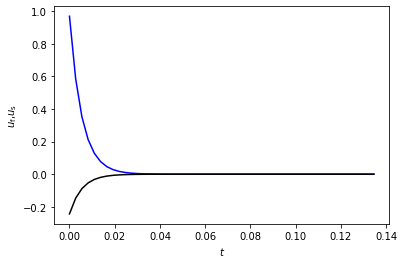

In [23]:
plt.plot(t_modeshow,u_f[0,:],'b',   t_modeshow,u_s[0,:],'k');
plt.xlabel("$t$");
plt.ylabel("$u_\\mathrm{f}$,$u_\\mathrm{s}$");
#plt.show();

Solid (black) and fluid (blue) move towards each other and slow down to rest.

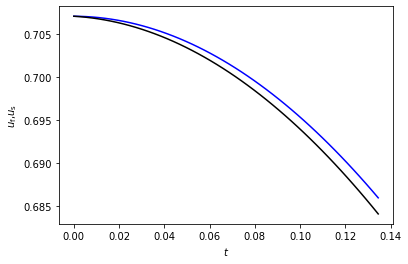

In [24]:
plt.plot(t_modeshow, u_f[1,:],'b',   t_modeshow, u_s[1,:],'k');
plt.xlabel("$t$");
plt.ylabel("$u_\\mathrm{f}$,$u_\\mathrm{s}$");
#plt.show();

Solid (black) and fluid (blue) motion are almost in phase with almost same amplitudes.  

Note, that second root of complex-conjugated pair gives the same plot as first.

### Discriminant
There is a discriminant for cubic polynomials indicating the number of real roots. However, for now we claim that there always is the rigid body mode ($\delta_0=0$), a decaying mode ($\delta_1\in\mathbb{R}$ and $\delta_1<0$) and an oscillation mode ($\delta_2, \delta_3\in\mathbb{C}$ and $\delta_2=\bar{\delta}_3$), i.e. S-waves exist always for physically plausible values. 
For the proof, we refer to this characteristic polynomial (S-waves) as a special case ($c_1=c_\Delta=0$) of the more general characteristic polynomial for the P-wave model in the next section (same structure, only different values of the coefficients).

### Higher modes

Characteristics of S-waves (takes some seconds)

In [25]:
Nk = 1000
d = np.zeros(Nk)   # decay constant
c = np.zeros(Nk)   # phase velocity approximation
f = np.zeros(Nk)   # frequency
AR = np.zeros(Nk)   # amplitude ratio
phi = np.zeros(Nk)   # phase angle

index_S = 1    # second and third eigenvalue compose wave mode

for k_num in range(Nk):
    
    I_11_num = float(I_11_k.subs(k, k_num))
    I_12_num = float(I_12_k.subs(k, k_num))
    I_22_num = float(I_22_k.subs(k, k_num))
    
    # redefine, since I_ij changes with higher modes
    nondim_num_k = [(I_11,  I_11_num),
                    (I_12,  I_12_num),
                    (I_22,  I_22_num),
                    (D_S,   D_S_num),
                    (D_P,   D_P_num),
                    (n,     n_num),
                    (alpha, alpha_num),
                    (M,     M_num),
                    (RHO,   RHO_num),
                    (tau,   tau_num)]
    
    ceq_num_reduced_Sk = ceq_nondim_reduced_S.subs(nondim_num_k + [(k, k_num)]).evalf()
    eigenvalue_sp = sp.solve(ceq_num_reduced_Sk, delta)
    eigenvalue_num = [complex(EVSP) for EVSP in eigenvalue_sp]
    d[k_num] = np.real(eigenvalue_num[index_S])
    omega = np.abs(np.imag(eigenvalue_num[index_S]))
    c[k_num] = omega/((k_num+1/2)*np.pi)    
    f[k_num] = omega/(2*np.pi)
    
    evp_num_Sk = evp_nondim_S.subs(nondim_num_k + [(k, k_num)]).evalf()
    EVP = evp_num_Sk.subs(delta, eigenvalue_num[index_S])
    evkr = np.array([1.0, -EVP[0,0].evalf()/EVP[0,1].evalf()], dtype=complex)   # first row --> eigenvector
    us_uf = evkr[1]/evkr[0]   # TODO exclude division by zero
    AR[k_num] = 1.0/np.absolute(us_uf)   # fluid-to-solid
    phi[k_num] = np.abs(np.angle(us_uf))

nondimensional c_el_S = 0.612372435695794


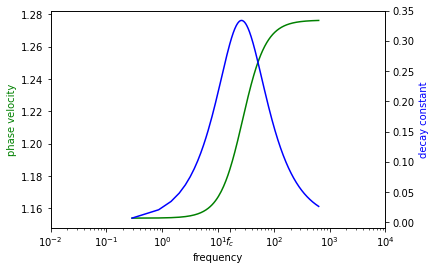

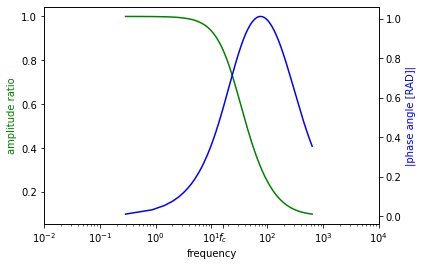

In [60]:
print("nondimensional c_el_S = {}".format(c_el_S_num/c_el_P_num))

fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.semilogx(f, c, 'g')
ax2.semilogx(f, np.abs(d)/f, 'b')
ax1.set_xlabel('frequency');
ax1.set_xticks(list(ax1.get_xticks()) + [f_critical_num], list(ax1.get_xticklabels()) + ['$f_c$'])   # with extra tick
ax1.set_ylabel('phase velocity', color='g');
ax2.set_ylabel('decay constant', color='b');
#tikzplotlib.save("s_wave_eigenvalue.tex", axis_height = '\\figH', axis_width = '\\figW')  

fig2, ax3 = plt.subplots()
ax4 = ax3.twinx()
ax3.semilogx(f, AR, 'g')
ax4.semilogx(f, phi, 'b')
ax3.set_xlabel('frequency');
ax3.set_xticks(list(ax3.get_xticks()) + [f_critical_num], list(ax3.get_xticklabels()) + ['$f_c$'])   # with extra tick
ax3.set_ylabel('amplitude ratio', color='g');
ax4.set_ylabel('|phase angle [RAD]|', color='b');
#tikzplotlib.save("s_wave_eigenvector.tex", axis_height = '\\figH', axis_width = '\\figW') 

Numbers for TikZ-plots (complex amplitudes and time history)

In [27]:
k_num = 0   # 0, 3, 30
print(f[k_num])
print(-d[k_num]/f[k_num])   # delta, with time axis scaled to period
print(AR[k_num]*np.cos(phi[k_num])) # u_fluid, real part, with u_solid = 1
print(AR[k_num]*np.sin(phi[k_num])) # u_fluid, imaginary part, with u_solid = 1

0.2884967039523798
0.0069192801172562315
0.9998799875247478
0.010957063414712098


## P-waves
Non-dimensional equations of motion for fluid phase (displacement $u_f$) and solid phase (displacement $u_s$)
\begin{align}
\frac{n}{\rho}\ddot{u}_\mathrm{f} + &\frac{n\tau}{\rho}(\ddot{u}_\mathrm{f}- \ddot{u}_\mathrm{s}) &+& n D_\text{P} (\dot{u}_\mathrm{f}-\dot{u}_\mathrm{s}) &-& nM\bigl(n u_\mathrm{f}'' - (n-\alpha)u_\mathrm{s}''\bigr) &=0, \\
(1-n) \ddot{u}_\mathrm{s} -& \frac{n\tau}{\rho} (\ddot{u}_\mathrm{f} - \ddot{u}_\mathrm{s}) &-& n D_\text{P} (\dot{u}_\mathrm{f}-\dot{u}_\mathrm{s}) &-& (n-\alpha)M \bigl(-n u_\mathrm{f}'' + (n-\alpha)u_\mathrm{s}''\bigr) - u_\mathrm{s}'' &=0,
\end{align}
with $\rho = \frac{\varrho_s}{\varrho_f}$, $M = \frac{m_v}{S_p}$ and $D_P = \frac{n\mu L\,\sqrt{m_v}\, }{\kappa \sqrt{\varrho_s}}$, note relation $D_P = \frac{c_\mathrm{S}^\mathrm{el}}{c_\mathrm{P}^\mathrm{el}}D_S$ with $\frac{c_\mathrm{S}^\mathrm{el}}{c_\mathrm{P}^\mathrm{el}} = \sqrt{m_v G}$. 

**Remarks** about the resulting formulation as multi-body system
- negative masses (interaction mass $m_\Delta$ in off-diagonal entries of mass matrix),
- complex eigenvectors (diagonalization of damping matrix with undamped eigenvectors is impossible),
- non-dimensional damping $D_P$ in P-waves is similar to the ratio $\frac{L f_\mathrm{c}}{V_\mathrm{c}}$ with bar length $L$ times characteristic frequency $f_\mathrm{c}$ \[Biot1956: eq.(7.4)\], which divides low- from high-frequency range, and reference velocity $V_\mathrm{c}$ in his notation \[Biot1956: equation (5.4)\],
- Biot refers to the velocity of dilatational waves in the undrained case $V_c = \sqrt{\frac{1/m_v + \alpha^2/S_p}{(1-n)\varrho_s + n \varrho_f}}$ and a critical frequency $f_c=\frac{1}{2\pi}\frac{\mu n}{\kappa \varrho_f}$ \[Biot1956: equations (5.4) and (7.4)\]. 

### Multi-body system matrices

Conversion between multi-body and non-dimensional continuum parameters

In [28]:
mbs2nondim_P = [(m_1,     I_11*n/RHO), 
                (m_2,     I_22*(1-n)), 
                (m_Delta, I_12*n*tau/RHO), 
                (d_Delta, I_12*n*D_P), 
                (c_1,     I_11*(((k+1/2)*sp.pi)**2)*n*M*alpha),
                (c_2,     I_22*(((k+1/2)*sp.pi)**2)*(1 - (n-alpha)*M*alpha)),
                (c_Delta, I_12*(((k+1/2)*sp.pi)**2)*(n-alpha)*M*n)]

m_1_num_P =         m_1.subs(mbs2nondim_P).subs(nondim_num_k0).evalf()
m_2_num_P =         m_2.subs(mbs2nondim_P).subs(nondim_num_k0).evalf()
m_Delta_num_P = m_Delta.subs(mbs2nondim_P).subs(nondim_num_k0).evalf() 
d_Delta_num_P = d_Delta.subs(mbs2nondim_P).subs(nondim_num_k0).evalf()
c_1_num_P =         c_1.subs(mbs2nondim_P).subs(nondim_num_k0 + [(k,k0)]).evalf()
c_2_num_P =         c_2.subs(mbs2nondim_P).subs(nondim_num_k0 + [(k,k0)]).evalf()
c_Delta_num_P = c_Delta.subs(mbs2nondim_P).subs(nondim_num_k0 + [(k,k0)]).evalf()
# masses
print('m_1(k=0)     = ' + str(m_1_num_P))
print('m_2(k=0)     = ' + str(m_2_num_P))
print('m_Delta(k=0) = ' + str(m_Delta_num_P))
# damping
print('d_Delta(k=0) = ' + str(d_Delta_num_P))
# springs
print('c_1(k=0)     = ' + str(c_1_num_P))
print('c_2(k=0)     = ' + str(c_2_num_P))
print('c_Delta(k=0) = ' + str(c_Delta_num_P))

m_1(k=0)     = 0.0754716981132076
m_2(k=0)     = 0.300000000000000
m_Delta(k=0) = 0.00754716981132076
d_Delta(k=0) = 7.64495147263002
c_1(k=0)     = 4.93480220054468
c_2(k=0)     = 8.63590385095319
c_Delta(k=0) = -2.96088132032681


mass matrix (symmetric)

In [29]:
mass_P = sp.Matrix(((m_1+m_Delta, -m_Delta), (-m_Delta, m_2+m_Delta)))
display(mass_P)

Matrix([
[m_1 + m_Delta,      -m_Delta],
[     -m_Delta, m_2 + m_Delta]])

damping matrix (symmetric)

In [30]:
damping_P = sp.Matrix(((d_Delta, -d_Delta), (-d_Delta, d_Delta)))
display(damping_P)

Matrix([
[ d_Delta, -d_Delta],
[-d_Delta,  d_Delta]])

stiffness matrix (symmetric)

In [31]:
stiffness_P = sp.Matrix(((c_1+c_Delta, -c_Delta), (-c_Delta, c_2+c_Delta)))
display(stiffness_P)

Matrix([
[c_1 + c_Delta,      -c_Delta],
[     -c_Delta, c_2 + c_Delta]])

check (swap relation) whether diagonalization with eigenvectors of undamped system is possible (answer is no, except degenerate cases)

In [32]:
inv_mass_P = sp.Matrix.inv(mass_P)
zero_or_not = (inv_mass_P*damping_P)*(inv_mass_P*stiffness_P) - (inv_mass_P*stiffness_P)*(inv_mass_P*damping_P)
display(sp.simplify(zero_or_not[0,0]))
display(sp.simplify(zero_or_not[0,1]))
display(sp.simplify(zero_or_not[1,0]))
display(sp.simplify(zero_or_not[1,1]))        

d_Delta*(-m_1*(c_Delta*(m_2 + m_Delta) - m_Delta*(c_2 + c_Delta)) + m_2*(c_Delta*(m_1 + m_Delta) - m_Delta*(c_1 + c_Delta)))/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

d_Delta*(m_1*(c_Delta*(m_2 + m_Delta) - m_Delta*(c_2 + c_Delta)) - m_2*(c_Delta*m_Delta - (c_1 + c_Delta)*(m_2 + m_Delta)) + m_2*(c_Delta*m_Delta - (c_2 + c_Delta)*(m_1 + m_Delta)) - m_2*(c_Delta*(m_2 + m_Delta) - m_Delta*(c_2 + c_Delta)))/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

d_Delta*(m_1*(c_Delta*m_Delta - (c_1 + c_Delta)*(m_2 + m_Delta)) - m_1*(c_Delta*m_Delta - (c_2 + c_Delta)*(m_1 + m_Delta)) - m_1*(c_Delta*(m_1 + m_Delta) - m_Delta*(c_1 + c_Delta)) + m_2*(c_Delta*(m_1 + m_Delta) - m_Delta*(c_1 + c_Delta)))/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

d_Delta*(m_1*(c_Delta*(m_2 + m_Delta) - m_Delta*(c_2 + c_Delta)) - m_2*(c_Delta*(m_1 + m_Delta) - m_Delta*(c_1 + c_Delta)))/(m_1*m_2 + m_1*m_Delta + m_2*m_Delta)**2

### Free vibrations

Eigenproblem and characteristic equation (MBS and non-dimensional formulation of 1D continuum) $a_4 \delta^4 + a_3 \delta^3 + a_2 \delta^2 + a_1 \delta + a_0 = 0$ with $a_4,a_3,a_2,a_1,a_0\in\mathbb{R}^+$ on physical grounds ($0\le \tau, \rho_\mathrm{f}, \rho_\mathrm{s}, m_v, S_p, \kappa, \mu$ and $0\le \alpha,n\le 1$).

In [33]:
evp_mbs_P = (delta**2)*mass_P + delta*damping_P + stiffness_P
ceq_mbs_P = sp.simplify(sp.Determinant(evp_mbs_P).doit())
display(ceq_mbs_P.collect(delta))

c_1*c_2 + c_1*c_Delta + c_2*c_Delta + delta**4*(m_1*m_2 + m_1*m_Delta + m_2*m_Delta) + delta**3*(d_Delta*m_1 + d_Delta*m_2) + delta**2*(c_1*m_2 + c_1*m_Delta + c_2*m_1 + c_2*m_Delta + c_Delta*m_1 + c_Delta*m_2) + delta*(c_1*d_Delta + c_2*d_Delta)

In [34]:
evp_nondim_P = evp_mbs_P.subs(mbs2nondim_P)
ceq_nondim_P = sp.simplify(ceq_mbs_P.subs(mbs2nondim_P))
#display(evp_continuum)
display(ceq_nondim_P.collect(delta))

n*(I_11*I_12*delta**4*n*tau + RHO**2*(-D_P*I_12*I_22*delta**3*(n - 1) - pi**4*I_11*I_12*M**2*alpha*n*(alpha - n)*(k + 0.5)**4 + pi**4*I_11*I_22*M*alpha*(k + 0.5)**4*(M*alpha*(alpha - n) + 1) - pi**4*I_12*I_22*M*(alpha - n)*(k + 0.5)**4*(M*alpha*(alpha - n) + 1) + delta**2*(-pi**2*I_11*I_22*M*alpha*(k + 0.5)**2*(n - 1) + pi**2*I_12*I_22*M*(alpha - n)*(k + 0.5)**2*(n - 1)) + delta*(pi**2*D_P*I_11*I_12*M*alpha*n*(k + 0.5)**2 + pi**2*D_P*I_12*I_22*(k + 0.5)**2*(M*alpha*(alpha - n) + 1))) + RHO*delta**2*(D_P*I_11*I_12*delta*n + pi**2*I_11*I_12*M*alpha*n*tau*(k + 0.5)**2 - pi**2*I_11*I_12*M*n*(alpha - n)*(k + 0.5)**2 + pi**2*I_11*I_22*(k + 0.5)**2*(M*alpha*(alpha - n) + 1) + pi**2*I_12*I_22*tau*(k + 0.5)**2*(M*alpha*(alpha - n) + 1) + delta**2*(-I_11*I_22*(n - 1) - I_12*I_22*tau*(n - 1))))/RHO**2

#### Numerical evaluation (example)

In [35]:
evp_num_P = evp_nondim_P.subs(nondim_num_k0 + [(k, k0)]).evalf()
ceq_num_P = ceq_nondim_P.subs(nondim_num_k0 + [(k, k0)]).evalf()
display(evp_num_P)
display(ceq_num_P)

Matrix([
[  0.0830188679245283*delta**2 + 7.64495147263002*delta + 1.97392088021787, -0.00754716981132076*delta**2 - 7.64495147263002*delta + 2.96088132032681],
[-0.00754716981132076*delta**2 - 7.64495147263002*delta + 2.96088132032681,    0.307547169811321*delta**2 + 7.64495147263002*delta + 5.67502253062638]])

0.000569597721609114*delta**4 + 2.29348544178901*delta**3 + 0.150943396226415*delta**2*(0.165*delta**2 + 3.82247573631501*delta + 3.51604656788808) + 0.592176264065361*delta**2 + 103.747389213028*delta + 2.43522727585006

In [36]:
eigenvalue_sp_P = sp.solve(ceq_num_P, delta)
eigenvalue_num_P = [complex(EVSP) for EVSP in eigenvalue_sp_P]
display(eigenvalue_num_P)
number_of_eigenvalues = len(eigenvalue_num_P)

[(-112.60616651317795+0j),
 (-0.02347826897748062+0j),
 (-0.023427456483021945-6.013025329969451j),
 (-0.023427456483021945+6.013025329969451j)]

Plot characteristic equation, intersections of zero-levels of real- and imaginary parts are roots of characteristic equation.

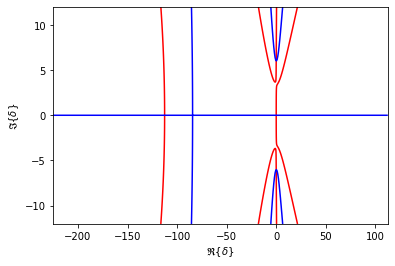

In [37]:
Xmin = min(np.real(eigenvalue_num_P))
Xmax = max(np.real(eigenvalue_num_P))
dX = Xmax - Xmin
Ymin = min(np.imag(eigenvalue_num_P))
Ymax = max(np.imag(eigenvalue_num_P))
dY = Ymax - Ymin
X = np.linspace(Xmin-dX, Xmax+dX, 500)
Y = np.linspace(Ymin-0.5*dY, Ymax+0.5*dY, 500)
XX, YY = np.meshgrid(X, Y)

ceq_f = sp.lambdify(delta, ceq_num_P, modules='numpy')
ZZ = ceq_f(XX+1j*YY)

plt.contour(XX, YY, np.real(ZZ), [0], colors='r');
plt.contour(XX, YY, np.imag(ZZ), [0], colors='b');
plt.xlabel("$\mathfrak{R}\{\delta\}$");
plt.ylabel("$\mathfrak{I}\{\delta\}$");
#plt.show();
#tikzplotlib.save("characteristic_roots.tex", axis_height = '\\figH', axis_width = '\\figW')   # im,re 

In [38]:
eigenvector_num_P = np.zeros((number_of_eigenvalues, 2), dtype=complex)
for mode_n, delta_n in enumerate(eigenvalue_num_P):
    EVP_P = evp_num_P.subs(delta, delta_n)
    ev0r = np.array([1.0, -EVP_P[0,0].evalf()/EVP_P[0,1].evalf()], dtype=complex)   # first row --> eigenvector
    ev0rn = ev0r/np.linalg.norm(ev0r)   # normalize
    #ev1r = np.array([1.0, -EVP_P[1,0].evalf()/EVP_P[1,1].evalf()], dtype=complex)   # second row, redundant
    #ev1rn = ev1r/np.linalg.norm(ev1r)   # normalize  
    print("--- {}. mode ---".format(mode_n))
    print("eigenvalue = {}  ".format(delta_n))
    print("eigenvector = [{}, {}]".format(ev0rn[0], ev0rn[1]))
    #print("eigenvector = [{}, {}] (redundant)".format(ev1rn[0], ev1rn[1]))
    eigenvector_num_P[mode_n,:] = ev0rn
t_scale = 1.0/(np.abs(min(np.imag(eigenvalue_num_P))) + np.abs(min(np.real(eigenvalue_num_P))))

--- 0. mode ---
eigenvalue = (-112.60616651317795+0j)  
eigenvector = [(0.9696162286236889+0j), (-0.24463108794585825+0j)]
--- 1. mode ---
eigenvalue = (-0.02347826897748062+0j)  
eigenvector = [(0.8682454328736874+0j), (-0.4961349295242001+0j)]
--- 2. mode ---
eigenvalue = (-0.023427456483021945-6.013025329969451j)  
eigenvector = [(0.7081195109350534+0j), (0.7052844153694529+0.03377353505438779j)]
--- 3. mode ---
eigenvalue = (-0.023427456483021945+6.013025329969451j)  
eigenvector = [(0.7081195109350534+0j), (0.7052844153694529-0.03377353505438779j)]


#### Visualize modes
Real roots lead to real coefficients, slow and fast decay, two of them together can match initial position and initial velocity of one component (either $v$ or $w$). Pair of complex-conjugated roots leads to damped oscillations, which can match initial conditions by amplitude and phase shift.

In [39]:
t_modeshow = np.linspace(0, 20*t_scale)
timesteps_modeshow = len(t_modeshow)
u_f = np.zeros((number_of_eigenvalues, timesteps_modeshow))
u_s = np.zeros((number_of_eigenvalues, timesteps_modeshow))

for mode_n, delta_n in enumerate(eigenvalue_num_P):
    u_f[mode_n,:] = np.real(eigenvector_num_P[mode_n,0]*np.exp(delta_n*t_modeshow))
    u_s[mode_n,:] = np.real(eigenvector_num_P[mode_n,1]*np.exp(delta_n*t_modeshow))

From the solution list above we see that first (0) and second mode (1) correspond to aperiodic decay (real roots), and third and fourth mode to damped oscillations (complex-conjugated roots):

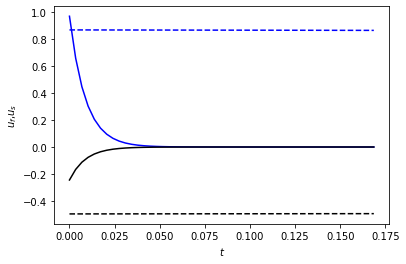

In [40]:
plt.plot(t_modeshow,u_f[0,:],'b',   t_modeshow,u_s[0,:],'k');
plt.plot(t_modeshow,u_f[1,:],'b--', t_modeshow,u_s[1,:],'k--');
plt.xlabel("$t$");
plt.ylabel("$u_f$,$u_s$");
#plt.show();

Solid motion (black) and fluid (blue) of first mode (solid line) and second mode (dashed line).

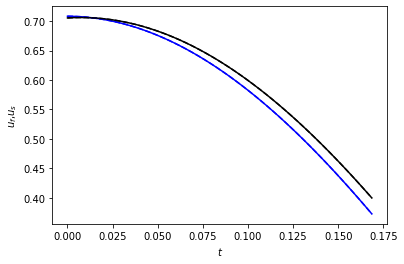

In [41]:
plt.plot(t_modeshow, u_f[2,:],'b',   t_modeshow, u_s[2,:],'k');
plt.plot(t_modeshow, u_f[3,:],'b--', t_modeshow, u_s[3,:],'k--');
plt.xlabel("$t$");
plt.ylabel("$u_f$,$u_s$");
#plt.show();

Solid motion (black) and fluid (blue) of third mode (solid line) and fourth mode (dashed line).

Note: 
- for complex-conjugated roots the curves of two modes are identical (no difference between dashed line and solid line) 
- the  waves (oscillations in reduced model) where fluid and solid move in counter-phase decay fast than waves with motion in-phase (physically due to higher dissipation). 

#### Specific initial conditions 
$u_f(0)$, $\dot{u}_f(0)$, $u_s(0)$, $\dot{u}_s(0)$

In [42]:
u_f0 = 2.0
ut_f0 = 3.0
u_s0 = 0.7
ut_s0 = 0.5

In [43]:
A = np.matrix([[eigenvector_num_P[mode_n, 0] for mode_n in range(number_of_eigenvalues)],
               [eigenvector_num_P[mode_n, 1] for mode_n in range(number_of_eigenvalues)],
               [eigenvector_num_P[mode_n, 0]*eigenvalue_num_P[mode_n] for mode_n in range(number_of_eigenvalues)],
               [eigenvector_num_P[mode_n, 1]*eigenvalue_num_P[mode_n] for mode_n in range(number_of_eigenvalues)]],
              dtype=complex)

In [44]:
b = np.matrix([[u_f0], [u_s0], [ut_f0], [ut_s0]], dtype=complex)

In [45]:
amplitude = np.linalg.solve(A, b)   # matrix with one column 

In [46]:
u_f_fit = lambda N,T: amplitude[N,0]*eigenvector_num_P[N,0]*np.exp(eigenvalue_num_P[N]*T) 
u_s_fit = lambda N,T: amplitude[N,0]*eigenvector_num_P[N,1]*np.exp(eigenvalue_num_P[N]*T) 

In [47]:
t_oscillation = np.linspace(0, 30*t_scale, 250)
timesteps_oscillation = len(t_oscillation)
u_f_oscillation = np.zeros(timesteps_oscillation, dtype=complex)
u_s_oscillation = np.zeros(timesteps_oscillation, dtype=complex)

for mode_n in range(number_of_eigenvalues):
    u_f_oscillation += u_f_fit(mode_n, t_oscillation)
    u_s_oscillation += u_s_fit(mode_n, t_oscillation)

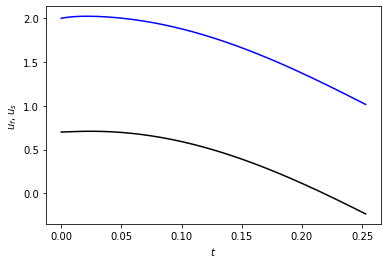

In [48]:
plt.plot(t_oscillation,np.real(u_f_oscillation),'b', t_oscillation,np.real(u_s_oscillation),'k');
plt.xlabel("$t$");
plt.ylabel("$u_f$, $u_s$");
#plt.show();

### Discriminant
Discriminant $D_4$ of a quartic equation $ax^4 + bx^3 + cx^2 + dx + e = 0 $. For real coefficients $a,b,c,d,e \in \mathbb{R}$
- $D_4 = 0$ at least two roots are equal,
- $D_4 < 0$ two real roots and one complex-conjugated pair,
- $D_4 > 0$ four real roots or two complex-conjugated pairs.

In [49]:
quartic_discriminant = lambda a,b,c,d,e: 256 * a**3 * e**3 \
    -192 * a**2 * b * d * e**2 \
    -128 * a**2 * c**2 * e**2 \
    +144 * a**2 * c * d**2 * e \
    -27 * a**2 * d**4 \
    +144 * a * b**2 * c * e**2 \
    -6 * a * b**2 * d**2 * e \
    -80 * a * b * c**2 * d * e \
    +18 * a * b * c * d**3 \
    +16 * a * c**4 *e \
    -4 * a * c**3 * d**2 \
    -27 * b**4 * e**2 \
    +18 * b**3 * c * d * e \
    -4 * b**3 * d**3 \
    -4 * b**2 * c**3 * e \
    + b**2 * c**2 * d**2

#### Dependency on MBS parameters

In [50]:
coefficients_mbs_P = ceq_mbs_P.collect(delta, evaluate=False)
a4_mbs_P = coefficients_mbs_P[delta**4] 
a3_mbs_P = coefficients_mbs_P[delta**3] 
a2_mbs_P = coefficients_mbs_P[delta**2] 
a1_mbs_P = coefficients_mbs_P[delta] 
a0_mbs_P = coefficients_mbs_P[sp.S.One] 

In [51]:
D4_mbs = sp.simplify(quartic_discriminant(a4_mbs_P, a3_mbs_P, a2_mbs_P, a1_mbs_P, a0_mbs_P))

In [52]:
D4_mbs_num = D4_mbs.subs([(m_1,m_1_num_P), (m_2,m_2_num_P), (m_Delta,m_Delta_num_P), (c_1,c_1_num_P), (c_2,c_2_num_P), (c_Delta, c_Delta_num_P)])
D4_mbs_d = sp.lambdify(d_Delta, D4_mbs_num, modules='numpy')

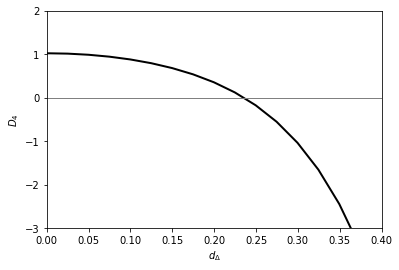

In [53]:
d_Delta_range = np.linspace(0.0, 0.16*float(d_Delta_num_P))
D4_mbs_range = D4_mbs_d(d_Delta_range)
plt.plot(d_Delta_range, D4_mbs_range, color='black', linewidth=2);
plt.plot([0,1],[0, 0], color='gray', linewidth=1);
plt.xlim((0,0.4))
plt.ylim((-3,2))
plt.xlabel('$d_\Delta$');
plt.ylabel('$D_4$');
#plt.show();
#tikzplotlib.save("d_crit.tex", axis_height = '\\figH', axis_width = '\\figW')   

The value of $d_\Delta$, when the discriminant $D_4$ changes its sign, corresponds to the change from oscillation ($D_4>0$), i.e. slow P-wave exists, to asymptotic decay ($D_4<0$), i.e. no slow P-wave.

In [54]:
d_Delta_crit_P = fsolve(D4_mbs_d, 0.8)
print('critical d_Delta = '+ str(d_Delta_crit_P[0]))

critical d_Delta = 0.2353623276385464


The dissipation seems most relevant, as it introduces the asymmetry to the characteristic polynomial, however the precise value of the critical $d_\Delta$ also depends on other parameters.

### Higher modes

Find wave characteristics for increasing values of eigenfrequencies (higher modes)

In [55]:
Nk = 1000
# slow P-wave
d1 = np.zeros(Nk)   # decay constant
c1 = np.zeros(Nk)   # phase velocity approximation
f1 = np.zeros(Nk)   # frequency 
AR1 = np.zeros(Nk)  # amplitude ratio
phi1 = np.zeros(Nk) # phase angle  
# fast P-wave
d2 = np.zeros(Nk)   # decay constant
c2 = np.zeros(Nk)   # phase velocity approximation
f2 = np.zeros(Nk)   # frequency
AR2 = np.zeros(Nk)  # amplitude ratio
phi2 = np.zeros(Nk) # phase angle  

index_slow = 0      # first and second eigenvalue compose first mode (slow)
index_fast = 2      # third and fourth eigenvalue compose first mode (fast) 

for k_num in range(Nk):
    
    I_11_num = float(I_11_k.subs(k, k_num))
    I_12_num = float(I_12_k.subs(k, k_num))
    I_22_num = float(I_22_k.subs(k, k_num))  

    # redefine, since I_ij changes with higher modes
    nondim_num_k = [(I_11,  I_11_num),
                    (I_12,  I_12_num),
                    (I_22,  I_22_num),
                    (alpha, alpha_num),  
                    (M,     M_num),
                    (D_P,   D_P_num),
                    (n,     n_num),
                    (RHO,   RHO_num),
                    (tau,   tau_num)]
    
    ceq_num_P = ceq_nondim_P.subs(nondim_num_k + [(k, k_num)]).evalf()  
    eigenvalue_sp = sp.solve(ceq_num_P, delta)
    eigenvalue_num = [complex(EVSP) for EVSP in eigenvalue_sp]
    
    
    d1[k_num] = np.real(eigenvalue_num[index_slow])   
    omega = np.abs(np.imag(eigenvalue_num[index_slow]))
    c1[k_num] = omega/((k_num+1/2)*np.pi)   
    f1[k_num] = omega/(2*np.pi)
    
    d2[k_num] = np.real(eigenvalue_num[index_fast])   
    omega = np.abs(np.imag(eigenvalue_num[index_fast]))
    c2[k_num] = omega/((k_num+1/2)*np.pi)   
    f2[k_num] = omega/(2*np.pi)
    
    evp_num_P = evp_nondim_P.subs(nondim_num_k + [(k, k_num)]).evalf()
    
    EVP = evp_num_P.subs(delta, eigenvalue_num[index_slow])
    evkr = np.array([1.0, -EVP[0,0].evalf()/EVP[0,1].evalf()], dtype=complex)   # first row --> eigenvector
    us_uf = evkr[1]/evkr[0]   # TODO exclude division by zero
    AR1[k_num] = 1.0/np.absolute(us_uf)   # fluid-to-solid
    phi1[k_num] = np.abs(np.angle(us_uf))
    
    EVP = evp_num_P.subs(delta, eigenvalue_num[index_fast])
    evkr = np.array([1.0, -EVP[0,0].evalf()/EVP[0,1].evalf()], dtype=complex)   # first row --> eigenvector
    us_uf = evkr[1]/evkr[0]   # TODO exclude division by zero
    AR2[k_num] = 1.0/np.absolute(us_uf)  # fluid-to-solid
    phi2[k_num] = np.abs(np.angle(us_uf))

Slow P-waves may exist only above a threshold frequency (depending on parameters, particularly dissipation). Maybe the actual threshold frequency is lower, but cannot be resolved more accurately by an integer number of modes.

In [56]:
nonzero_f = f1.nonzero();    # only when there is an frequency (wave exists)
print("Slow P-waves exist from {}. mode on corresponding to a frequency of f = {}".format(nonzero_f[0][0]+1, f1[nonzero_f[0][0]]))

Slow P-waves exist from 17. mode on corresponding to a frequency of f = 1.44382921054289


Characteristics of slow P-waves

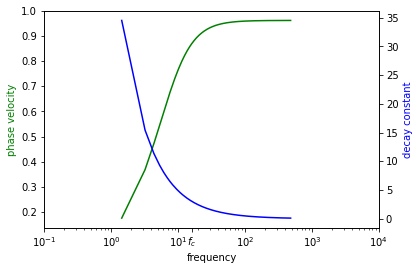

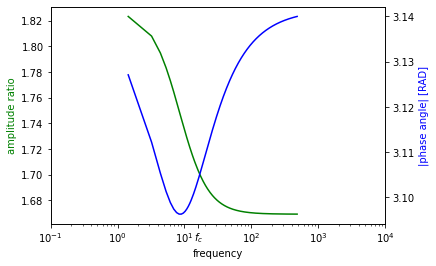

In [61]:
fig3, ax5 = plt.subplots();
ax6 = ax5.twinx();
ax5.semilogx(f1[nonzero_f], c1[nonzero_f], 'g');
ax6.semilogx(f1[nonzero_f], np.abs(d1[nonzero_f])/f1[nonzero_f], 'b');   # frequency may be zero so decay instead of damping ratio
ax5.set_xlabel('frequency');
#ax5.set_ylim([0, 1])
ax5.set_xticks(list(ax5.get_xticks()) + [f_critical_num], list(ax5.get_xticklabels()) + ['$f_c$'])   # with extra tick
ax5.set_ylabel('phase velocity', color='g');
ax6.set_ylabel('decay constant', color='b');   
#ax6.set_ylim([0, 10])
#tikzplotlib.save("p_wave_slow_eigenvalue.tex", axis_height = '\\figH', axis_width = '\\figW')   

fig4, ax7 = plt.subplots();
ax8 = ax7.twinx();
ax7.semilogx(f1[nonzero_f], AR1[nonzero_f], 'g');
ax8.semilogx(f1[nonzero_f], phi1[nonzero_f], 'b');
ax7.set_xlabel('frequency');
#ax7.set_ylim([0,2.5])
ax7.set_xticks(list(ax7.get_xticks()) + [f_critical_num], list(ax7.get_xticklabels()) + ['$f_c$'])   # with extra tick
ax7.set_ylabel('amplitude ratio', color='g');
ax8.set_ylabel('|phase angle| [RAD]', color='b');
#ax8.set_ylim([-1.2,0])
#tikzplotlib.save("p_wave_slow_eigenvector.tex", axis_height = '\\figH', axis_width = '\\figW') 

Characteristics of fast P-waves

nondimensional c_un_P = 3.82730207927597


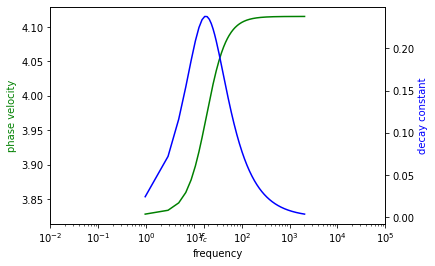

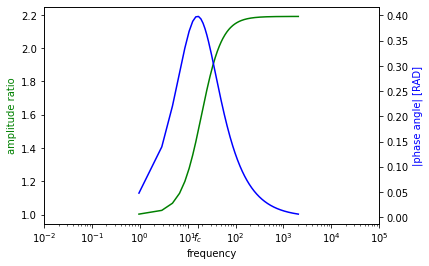

In [62]:
print("nondimensional c_un_P = {}".format(c_un_P_num/c_el_P_num))

fig5, ax9 = plt.subplots();
ax10 = ax9.twinx();
ax9.semilogx(f2, c2, 'g');
ax10.semilogx(f2, np.abs(d2)/f2, 'b');
#ax9.set_ylim([0,2])
ax9.set_xlabel('frequency');
ax9.set_xticks(list(ax9.get_xticks()) + [f_critical_num], list(ax9.get_xticklabels()) + ['$f_c$'])   # with extra tick
ax9.set_ylabel('phase velocity', color='g');
ax10.set_ylabel('decay constant', color='b');
#ax10.set_ylim([0,1.2e-5])
#tikzplotlib.save("p_wave_fast_eigenvalue.tex", axis_height = '\\figH', axis_width = '\\figW')   

fig6, ax11 = plt.subplots();
ax12 = ax11.twinx();
#ax11.set_ylim([0,1])
ax11.semilogx(f2, AR2, 'g');
ax12.semilogx(f2, phi2, 'b');
ax11.set_xlabel('frequency');
#ax12.set_ylim([-1.0,0])
ax11.set_xticks(list(ax11.get_xticks()) + [f_critical_num], list(ax11.get_xticklabels()) + ['$f_c$'])   # with extra tick
ax11.set_ylabel('amplitude ratio', color='g');
ax12.set_ylabel('|phase angle| [RAD]', color='b');
#tikzplotlib.save("p_wave_fast_eigenvector.tex", axis_height = '\\figH', axis_width = '\\figW') 

Numbers for TikZ-plots (complex amplitudes and time history)

In [59]:
k_num = 17   # first mode with slow P-wave
print(f1[k_num])
print(-d1[k_num]/f1[k_num])   # delta, with time axis scaled to period
print((1/AR1[k_num])*np.cos(-phi1[k_num])) # u_solid, real part, with u_fluid = 1
print((1/AR1[k_num])*np.sin(-phi1[k_num])) # u_solid, imaginary part, with u_fluid = 1
print('--')
print(f2[k_num])
print(-d2[k_num]/f2[k_num])   # delta, with time axis scaled to period
print(AR2[k_num]*np.cos(phi2[k_num])) # u_fluid, real part, with u_solid = 1
print(AR2[k_num]*np.sin(phi2[k_num])) # u_fluid, imaginary part, with u_solid = 1

3.2217809087542135
15.428731300019512
-0.5528896710282588
-0.016246643218895983
--
35.500010749217836
0.1867677715845588
1.8344734513654677
0.5654385045836885


## References
- \[Biot1956\]   M.A. Biot; _Theory of Propagation of Elastic Waves in a Fluid-saturated Porous Solid -- I. Low-frequency Range_; Journal of the Acoustical Society of America 28(2); 1956.
- \[Verruijt2010\]   A. Verruijt; _An Introduction to Soil Dynamics_; Springer Dordrecht Heidelberg London New York; 2010.
- \[Hagedorn2012\] P. Hagedorn, D. Hochlehnert; _Technische Schwingungslehre: Schwingungen linearer diskreter mechanischer Systeme_; Europa-Lehrmittel, 2021.